In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

xls = pd.ExcelFile('/Users/maga/Downloads/data_task.xlsx')

In [51]:
nikkei500 = pd.read_excel(xls, 'NIKKEI 225', parse_dates=[['Date','Time']])
dj_euro_stoxx50 = pd.read_excel(xls, 'DJ EURO STOXX 50', parse_dates=[['Date','Time']])
sp500 = pd.read_excel(xls, 'SP500', parse_dates=[['Date','Time']])
ftse_china_a50 = pd.read_excel(xls, 'FTSE China A50', parse_dates=[['Date','Time']])

Для оценки влияния я решил через метод временных рядов смотреть прирост или упадка индекса по Close минутных свечек. Затем сделать через градиентный бустинг модель по предсказыванию процентного роста у Азиатского рынка. Тестируем модель на Азиатской  тестовой выборке, смотрим ошибку модели, затем тестируем эту же "азиатскую" модель, но уже на Европейский и Американский рынок. Если у модели в целом небольшая ошибка между фактическими и предсказанными значениями и самое главное ее ошибка приближенно к Европейской или Американской выборке - то можно сказать, что "Азиатские" признаки, которые одинаково условно хорошо предсказывают и свою выборку и Европа/США - Между Азитаским индексом и Западом имеется хорошая взаимосвязь.  

# Этапы работы

1) Подготовка функций для перевода во временной ряд и функция модели градиентного бустинга
<br>
2) Анализ и сравнение азиатских моделей на выборках из Европейского и Американского рынка - расчет и разницу MAE
<br>
3) Список моделей и сравнение разницы MAE в каждом кейсе между Японским и Китайским рынков
<br>
4) Итоговое решение

# 0. Предрасчетные функции, которые будем использовать для всех Кейсов условий

In [193]:
#h - сколько часов прибавляем для перевод с EST (sp500 время) на другие рынки
#nikkei - +14 (Tokyo)
#dj euro - +6 (Frankfurt)
#china - +13 (Hong-Kong)

def time_changing(data, time_sample, h):
    
    df = data[['Date_Time','Close']].query('Date_Time > "2020.06.01 00:00:00"')
    df['Date_Time'] = df['Date_Time'] + pd.DateOffset(hours = h)
    df = df.set_index('Date_Time')
    df.sort_index(inplace=True)

    df = df.resample(time_sample, base = 1).mean()

    df['growth_rate'] = df.pct_change(fill_method='ffill', periods = 1)*100
    df.drop('Close', axis = 1, inplace=True)
    df = df.iloc[1:]
    
    return df

nik = time_changing(nikkei500, '10min', 14) #10

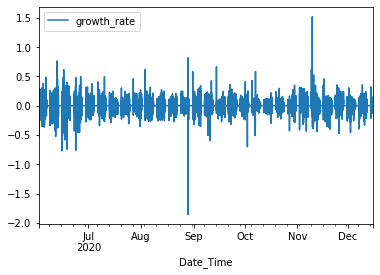

In [194]:
nik.plot()

In [195]:
#nik = nik - nik.shift()
#nik['mean'] = nik['growth_rate'].rolling(15).mean()
#nik['std'] = nik['growth_rate'].rolling(15).std()
#nik.plot()

In [196]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['minute'] = data.index.minute
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['growth_rate'].shift(lag)

    data['rolling_mean'] = data['growth_rate'].shift().rolling(rolling_mean_size).mean()

In [197]:
def model_pred(data):
    
    make_features(data, 6, 5)

    train, test = train_test_split(data, shuffle=False, test_size=0.2)
    train = train.dropna()

    train_1 = train.drop(['growth_rate'],axis=1)
    train_2 = train['growth_rate']

    test_1 = test.drop(['growth_rate'],axis=1)
    test_2 = test['growth_rate']

    model = CatBoostRegressor(iterations=5,
                          learning_rate=1,
                          depth=4, verbose = False)

    model.fit(train_1,train_2)

    pred = model.predict(test_1)
    
    return model, pred, test_2, test_1

# 1) Азиатский рынок и европейский рынок (полная сессия)

MAE тестовой выборки:  0.03386286803014968


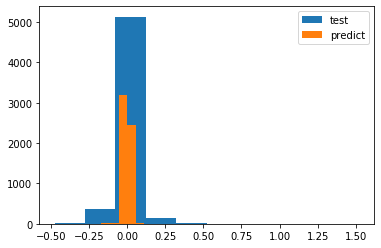

In [198]:
model, pred, test_2, test_1 = model_pred(nik)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

mae_nik_full = mean_absolute_error(test_2 , pred)
model_jp_full_session = model

MAE тестовой выборки:  0.033501586925853574


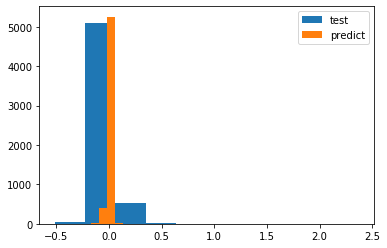

In [199]:
dj_euro = time_changing(dj_euro_stoxx50, '10Min', 6) #10

euro_model, euro_pred, eu_test_2, eu_test_1 = model_pred(dj_euro)

"Используем модель азиатиского рынка на тестовую выборку у европейского "

predict_eu = model.predict(eu_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(eu_test_2 , predict_eu))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

"""Соотвественно, можно сказать, что модель с азиатского прогнозирует выборку из европейского практическая совпадая, что можно сказать
влияние одного рынка на другое имеется, учитывая, что ошибка MAE у Европейского и Японского совпадает, и им"""

"""Модели с большой точностью не попадают тк разницы цен не очень велики, но верно показывает в каком направлении двигается рынок"""

mae_eu_full = mean_absolute_error(eu_test_2 , predict_eu)
mae_jp_eu_diff = mae_eu_full - mae_nik_full

MAE тестовой выборки:  0.02839296102941917


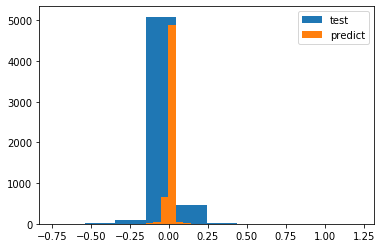

In [200]:
china = time_changing(ftse_china_a50, '10Min', 13) #10

model, pred, test_2, test_1 = model_pred(china)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_china_full_session = model
mae_china_full = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.03398435971505052


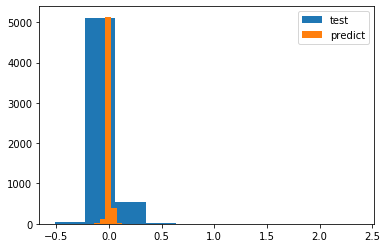

In [201]:
predict_eu = model.predict(eu_test_1)

"Аналогично смотрим Китайский и Европейский рынок"

print("MAE тестовой выборки: ", mean_absolute_error(eu_test_2 , predict_eu))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

"""Ошибки MAE у Китайского и Европейского разнятся на 0.06%, влияние имеется, но слабее, чем у Японского """

mae_eu_full = mean_absolute_error(eu_test_2 , predict_eu)
mae_ch_eu_diff =  mae_eu_full - mae_china_full

# 2) Азиатский рынок и европейский рынок (первый час торгов)

In [202]:
start = datetime.strptime('09:00:00', '%H:%M:%S').time()
end = datetime.strptime('10:00:00', '%H:%M:%S').time()


nik1 = nikkei500[nikkei500['Date_Time'].dt.time.between(start, end)]
dj_euro1 = dj_euro_stoxx50[dj_euro_stoxx50['Date_Time'].dt.time.between(start, end)]
china1 = ftse_china_a50[ftse_china_a50['Date_Time'].dt.time.between(start, end)]

nik = time_changing(nik1, '1Min', 14)
dj_euro = time_changing(dj_euro1, '1Min', 6)
china = time_changing(china1, '1Min', 13)

MAE тестовой выборки:  0.00121206080255125


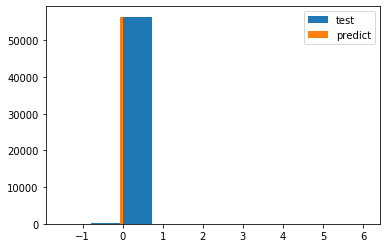

In [203]:
model, pred, test_2, test_1 = model_pred(nik)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_jp_first_session = model
mae_jp_first = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.03358341138487048


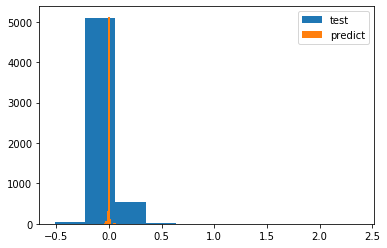

In [204]:
predict_eu = model.predict(eu_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(eu_test_2 , predict_eu))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

"В следствии большой разности ошибок MAE, то Японский на Европейский в первый час торгов влияние не имеет"

mae_eu_first = mean_absolute_error(eu_test_2 , predict_eu)
mae_jp_eu_first_diff = mae_eu_first - mae_jp_first

MAE тестовой выборки:  0.0010342595398429055


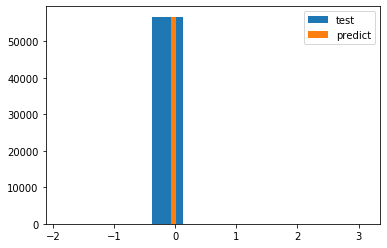

In [205]:
model, pred, test_2, test_1 = model_pred(china)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_ch_first_session = model
mae_ch_first = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.0334487593507684


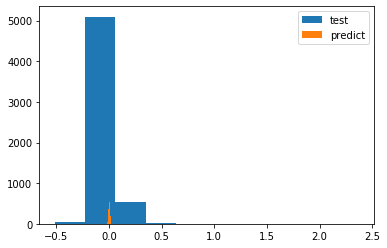

In [206]:
predict_eu = model.predict(eu_test_1)

"Аналогично смотрим Китайский и Европейский рынок"

print("MAE тестовой выборки: ", mean_absolute_error(eu_test_2 , predict_eu))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

"Аналогично с Китайским и Европейским рынками - влияние не имеется"

mae_ch_eu_first = mean_absolute_error(eu_test_2 , predict_eu)
mae_ch_eu_first_diff = mae_ch_eu_first - mae_ch_first

# 3) Азиатский рынок и американский рынок (полная НЕ основная сессия)

In [207]:
start = datetime.strptime('09:30:00', '%H:%M:%S').time()
end = datetime.strptime('16:00:00', '%H:%M:%S').time()


nik_1 = nikkei500[nikkei500['Date_Time'].dt.time < start]
nik_2 = nikkei500[nikkei500['Date_Time'].dt.time > end]                
nik_3 = nik_1.merge(nik_2, how = 'outer')

dj_1 = sp500[sp500['Date_Time'].dt.time < start]
dj_2 = sp500[sp500['Date_Time'].dt.time > end]                
dj_3 = dj_1.merge(dj_2, how = 'outer')

ch_1 = ftse_china_a50[ftse_china_a50['Date_Time'].dt.time < start]
ch_2 = ftse_china_a50[ftse_china_a50['Date_Time'].dt.time > end]                
ch_3 = ch_1.merge(ch_2, how = 'outer')


nik = time_changing(nik_3, '10Min', 14) #10
us500 = time_changing(dj_3, '10Min', 0)
china = time_changing(ch_3, '10Min', 13)

MAE тестовой выборки:  0.02737048890611321


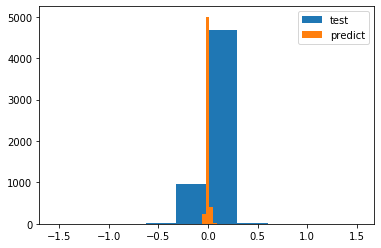

In [208]:
model, pred, test_2, test_1 = model_pred(nik)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_jp_full_not_gen = model
mae_jp_full_not_gen = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.022173223784669103


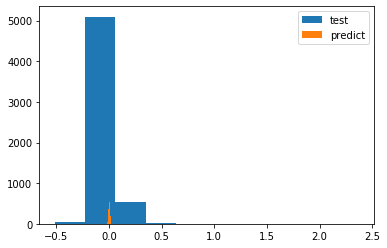

In [209]:
us_model, us_pred, us_test_2, us_test_1 = model_pred(us500)

predict_us = model.predict(us_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(us_test_2 , predict_us))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

"Разница в ошибке 0.005% между Японской модели на своей выборке и на Американской выборке. Разница не велика при разбросе до 0.5%"

mae_us_not_full = mean_absolute_error(us_test_2 , predict_us)
mae_jp_us_not_full_diff = mae_eu_not_full - mae_jp_full_not_gen

MAE тестовой выборки:  0.02513006533105326


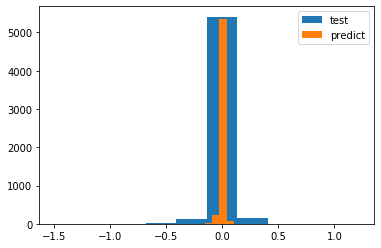

In [210]:
model, pred, test_2, test_1 = model_pred(china)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_ch_full_not_gen = model
mae_ch_not_full = mean_absolute_error(test_2 , pred) 

MAE тестовой выборки:  0.022418796543420525


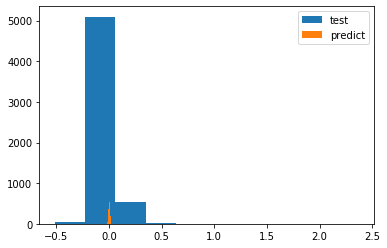

In [211]:
predict_us = model.predict(us_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(us_test_2 , predict_us))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

"C Китайским рынком у Америки на 0.003%, влияние ненамного сильнее, чем у Америки с Европой"

mae_ch_us_not_full = mean_absolute_error(us_test_2 , predict_us)
mae_ch_us_not_full_diff = mae_ch_us_not_full - mae_ch_not_full

# 4) Азиатский рынок и американский рынок (полная основная сессия)

In [212]:
start = datetime.strptime('09:30:00', '%H:%M:%S').time()
end = datetime.strptime('16:00:00', '%H:%M:%S').time()


nik1 = nikkei500[nikkei500['Date_Time'].dt.time.between(start, end)]
dj_euro1 = dj_euro_stoxx50[dj_euro_stoxx50['Date_Time'].dt.time.between(start, end)]
china1 = ftse_china_a50[ftse_china_a50['Date_Time'].dt.time.between(start, end)]

nik = time_changing(nik1, '5Min', 14) #5
us500 = time_changing(dj_euro1, '5Min', 0)
china = time_changing(china1, '5Min', 13)

MAE тестовой выборки:  0.00951769046900962


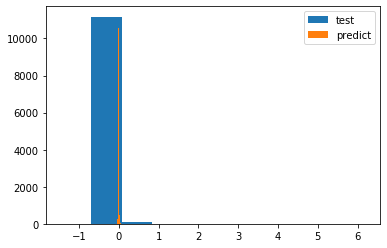

In [213]:
model, pred, test_2, test_1 = model_pred(nik)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_jp_full_gen = model
mae_jp_full_gen = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.01034174188422457


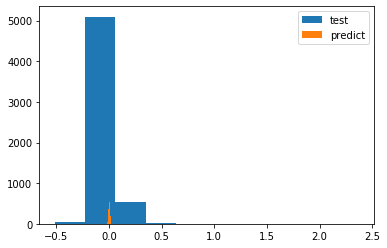

In [214]:
us_model, us_pred, us_test_2, us_test_1 = model_pred(us500)

predict_us = model.predict(us_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(us_test_2 , predict_us))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

mae_us_full_gen = mean_absolute_error(us_test_2 , predict_us)
mae_jp_us_full_gen_diff = mae_us_full_gen - mae_jp_full_gen

MAE тестовой выборки:  0.006947149247334368


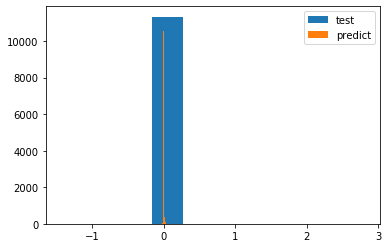

In [215]:
model, pred, test_2, test_1 = model_pred(china)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_ch_full_gen = model
mae_ch_full_gen = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.010914357743752101


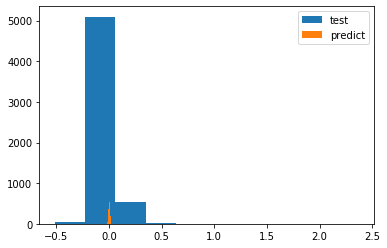

In [216]:
predict_us = model.predict(us_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(us_test_2 , predict_us))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

mae_us_full_gen = mean_absolute_error(us_test_2 , predict_us)
mae_ch_us_full_gen_diff = mae_us_full_gen - mae_ch_full_gen

Японский и Американский имееют малу разницу в 0.01% и соотвественно у Китая с Америкой разница в 0.03%

# 5) Азиатский рынок и американский рынок (первый час торгов основной  сессии)


In [217]:
start = datetime.strptime('09:30:00', '%H:%M:%S').time()
end = datetime.strptime('10:30:00', '%H:%M:%S').time()


nik1 = nikkei500[nikkei500['Date_Time'].dt.time.between(start, end)]
dj_euro1 = dj_euro_stoxx50[dj_euro_stoxx50['Date_Time'].dt.time.between(start, end)]
china1 = ftse_china_a50[ftse_china_a50['Date_Time'].dt.time.between(start, end)]

nik = time_changing(nik1, '1Min', 14)
us500 = time_changing(dj_euro1, '1Min', 0)
china = time_changing(china1, '1Min', 13)

MAE тестовой выборки:  0.0014117303816431918


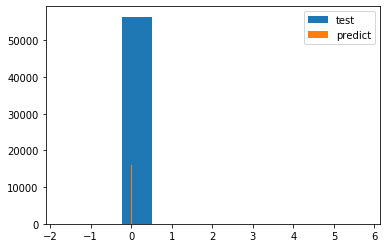

In [218]:
model, pred, test_2, test_1 = model_pred(nik)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_jp_first_gen = model
mae_jp_first_gen = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.0015487968056956808


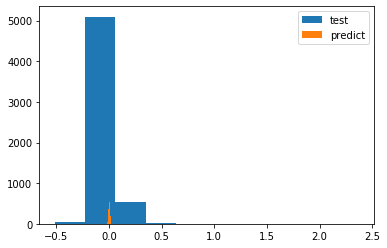

In [219]:
us_model, us_pred, us_test_2, us_test_1 = model_pred(us500)

predict_us = model.predict(us_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(us_test_2 , predict_us))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

mae_us_first_gen = mean_absolute_error(us_test_2 , predict_us)
mae_jp_us_first_gen_diff = mae_us_first_gen - mae_jp_first_gen

MAE тестовой выборки:  0.0013386149310602889


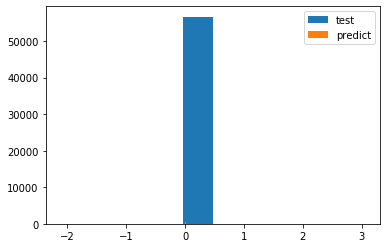

In [220]:
model, pred, test_2, test_1 = model_pred(china)

print("MAE тестовой выборки: ", mean_absolute_error(test_2 , pred))
plt.hist(test_2, label = 'test')
plt.hist(pred, label = 'predict')
plt.legend()

model_ch_first_gen = model
mae_ch_first_gen = mean_absolute_error(test_2 , pred)

MAE тестовой выборки:  0.0017447827608127204


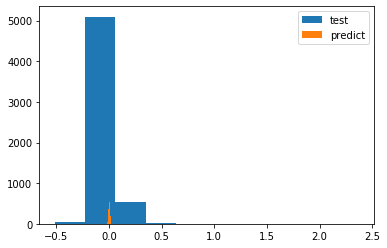

In [221]:
predict_us = model.predict(us_test_1)

print("MAE тестовой выборки: ", mean_absolute_error(us_test_2 , predict_us))
plt.hist(eu_test_2, label = 'test')
plt.hist(predict_eu, label = 'predict')
plt.legend()

mae_us_first_gen = mean_absolute_error(us_test_2 , predict_us)
mae_ch_us_first_gen_diff = mae_us_first_gen - mae_ch_first_gen

Первый час торгов основной сессии у Азиатского рынка с Американским в целом очень малый разброс процента доходности, тут нельзя сказать точно имеет ли влияния друг на друга

Список всех моделей:

In [222]:
#Модели для оценки европейского рынка - полная сессия и первый час торгов - Японская и Китайская
"""model_jp_full_session
model_china_full_session

model_jp_first_session
model_ch_first_session"""


#Модели для оценки Американского рынка - полная не основная сессия, полная основная и первый час основной - Японская и Китайская
"""model_jp_full_not_gen
model_ch_full_not_gen

model_jp_full_gen
model_ch_full_gen

model_jp_first_gen
model_ср_first_gen"""

'model_jp_full_not_gen\nmodel_ch_full_not_gen\n\nmodel_jp_full_gen\nmodel_ch_full_gen\n\nmodel_jp_first_gen\nmodel_ср_first_gen'

Ниже наблюдаем разности ошибок MAE азиатских моделей c Европейским и Американским рынком (отрицательные значения говорят нам о том, что на тестовой европейской или американской выборке азиатская модель предсказала лучше, чем на выборке из своего рынка)

In [223]:
print('Полная основная сессия')
print("Японская модель на Европейском рынке: ", mae_jp_eu_diff)
print("Китайская модель на Европейском рынке: ", mae_ch_eu_diff)

Полная основная сессия
Японская модель на Европейском рынке:  -0.0003612811042961045
Китайская модель на Европейском рынке:  0.005591398685631348


In [224]:
print('Первый час торгов')
print("Японская модель на Европейском рынке: ", mae_jp_eu_first_diff)
print("Китайская модель на Европейском рынке: ", mae_ch_eu_first_diff)

Первый час торгов
Японская модель на Европейском рынке:  0.032371350582319235
Китайская модель на Европейском рынке:  0.0324144998109255


In [225]:
print('Полная не основная сессия')
print("Японская модель на Американском рынке: ", mae_jp_us_not_full_diff)
print("Китайская модель на Американском рынке: ", mae_ch_us_not_full_diff)

Полная не основная сессия
Японская модель на Американском рынке:  -0.005197265121444108
Китайская модель на Американском рынке:  -0.002711268787632736


In [226]:
print('Полная основная сессия')
print("Японская модель на Американском рынке: ", mae_jp_us_full_gen_diff)
print("Китайская модель на Американском рынке: ", mae_ch_us_full_gen_diff)

Полная основная сессия
Японская модель на Американском рынке:  0.0008240514152149502
Китайская модель на Американском рынке:  0.003967208496417733


In [227]:
print('Первый час основной сессии')
print("Японская модель на Американском рынке: ", mae_jp_us_first_gen_diff)
print("Китайская модель на Американском рынке: ", mae_ch_us_first_gen_diff)

Первый час основной сессии
Японская модель на Американском рынке:  0.000137066424052489
Китайская модель на Американском рынке:  0.0004061678297524315


В ходе решении кейсов зависимость была найдена у 1), 3) и 4). У 2) разница ошибки велика, а у 5) слишком малый разброс у процентных изменений цен, чтобы говорить о зависимости.

# Итог

Соотвественно в кейсах, где выявлена зависимость берем ту модель, чья разница ошибки меньше

1) В первом кейсе  - это Японская: model_jp_full_session
<br>
2) В третьем кейсе - это Китайская: model_ch_full_not_gen
<br>
3) В четвертом кейсе - это Японская: model_jp_full_gen

НО! Зная, как отторговались в Азии лучше использовать функцию 

1) time_changing() на данные последнего дня в Азии
<br>
2) Корректировать growth_rate (процент изменения цен) на разницу ошибки из модели (growth_rate*abs(mae_diff))
<br>
3) Соотвественно для 1. кейса берем mae_jp_eu_diff, для 3. mae_ch_us_not_full_diff, и для 4. mae_jp_us_full_gen_diff